In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from tqdm import tqdm
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

This notebook uses a pretrained (supervised) RAFT model to estimate optical flow.

The script 'cwm/models/raft/download_raft_checkpoints.sh' will download these checkpoints.

In [5]:
from cwm.models.raft.raft_model import load_raft_model
from cwm.data.utils import FlowToRgb

if not os.path.exists('../checkpoints/raft_checkpoints/'):
    os.system('../cwm/models/raft/download_raft_checkpoints.sh')

In [32]:
## Load a RAFT model for predicting flow of counterfactual movies
raft = load_raft_model().to(DEVICE)

<All keys matched successfully> RAFT ../../../checkpoints/raft_checkpoints/raft-large.pth


### Load a masked predictor for generating counterfactual movies

In [8]:
## Download checkpoint for base 8x8 model
model_checkpoint_dir = os.path.expanduser('../../CounterfactualWorldModels/checkpoints')
if not os.path.exists(model_checkpoint_dir):
    os.makedirs(model_checkpoint_dir)
    
## download base 8x8 2-frame model
base8x8_url = 'https://counterfactual-world-modeling.s3.amazonaws.com/cwm_baseVMAE_224px_8x8patches_2frames.pth'
base4x4_url = 'https://counterfactual-world-modeling.s3.amazonaws.com/cwm_largeVMAE_224px_4x4patches_2frames.pth'

!wget -nc --show-progress -P $model_checkpoint_dir $base8x8_url
!wget -nc --show-progress -P $model_checkpoint_dir $base4x4_url

File ‘../../CounterfactualWorldModels/checkpoints/cwm_baseVMAE_224px_8x8patches_2frames.pth’ already there; not retrieving.

File ‘../../CounterfactualWorldModels/checkpoints/cwm_largeVMAE_224px_4x4patches_2frames.pth’ already there; not retrieving.



In [9]:
## build and load a VMAE pretrained with the temporally-factored masking policy
import cwm.models.VideoMAE.vmae as vmae

DEVICE = torch.device('cpu')
USE_GPU = True

if torch.cuda.is_available() and USE_GPU:
    DEVICE = torch.device('cuda:0')
elif torch.backends.mps.is_available() and USE_GPU:
    DEVICE = torch.device('mps')
    
USE_FLASH = 'cuda' in str(DEVICE.type)

## to use base 8x8 model, uncomment this line
model_func = vmae.base_8x8patch_2frames_1tube
model_path = os.path.join(model_checkpoint_dir, base8x8_url.split('/')[-1])

## to use large 4x4 model, uncomment this line
# model_func = vmae.large_4x4patch_2frames_1tube
# model_path = os.path.join(model_checkpoint_dir, base4x4_url.split('/')[-1])

model = model_func(use_flash_attention=(USE_FLASH))
model.eval().requires_grad_(False).to(DEVICE)
print("Num parameters: %d" % sum([v.numel() for v in model.parameters()]))

did_load = model.load_state_dict(torch.load(model_path, map_location='cpu')['model'])
print(did_load, model_func.__name__, model_path, "device: %s" % DEVICE)

NUM PATCHES IN ENCODER 1568
Num parameters: 92661312
<All keys matched successfully> base_8x8patch_2frames_1tube ../../CounterfactualWorldModels/checkpoints/cwm_baseVMAE_224px_8x8patches_2frames.pth device: mps


In [27]:
'''
Create a way of generating mask inputs to the model, and wrap it for easy prediction
We call the model wrapper Psi, whose main method is making a prediction, y, via
 
      y = Psi.predict(x, mask)
      
where
     - x is a video of shape (B,2,3,*model.img_size)
     - mask is a boolean mask of shape (B, num_patches), with num_patches = np.prod(model.mask_size)
     
'''

import cwm.models.masking as masking
import cwm.models.segmentation as segmentation

MASK_RATIO = 0.99
CLUMPING_FACTOR = 1

# an object that generates temporally-factored masks. mask_ratio of the second frame is masked out.
# clumping_factor determines how much visible patches will be clumped (default 1)
mask_generator = masking.RotatedTableUniformMaskingGenerator(
    input_size=model.mask_size,
    mask_ratio=MASK_RATIO,
    clumping_factor=CLUMPING_FACTOR,
    randomize_num_visible=False,
    always_batch=True,
    seed=0
).requires_grad_(False).to(DEVICE)

# the wrapper for making predictions
Psi = segmentation.FlowGenerator(
        predictor=model, # the model function with loaded weights
        temporal_dim=2, # the base models take inputs of shape [B,3,T,H,W]; the wrapper Psi handles reshaping
        imagenet_normalize_inputs=True, # because these models were trained with normalization
        mask_generator=mask_generator, # a way of generating masks automatically if desired
        seed=0,
        flow_model=raft # set RAFT to easily evaluate flow
).requires_grad_(False).to(DEVICE)

# 
mask = mask_generator()
print("\n")
print("example mask shape: %s" % list(mask.shape))
print("number of visible patches: %d" % mask.sum().item())

No predictor weights were loaded in constructing the FlowGenerator
This is fine as long as you already loaded the weights!
set RAFT to 24 iters


example mask shape: [1, 1568]
number of visible patches: 776


/Users/db/neuroailab/.neuroailab/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input shape: [1, 2, 3, 224, 224]


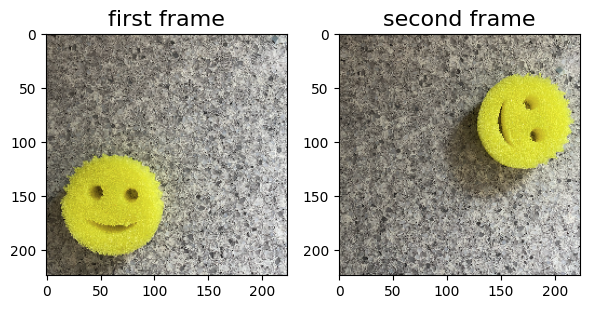

In [28]:
# create demo movie
from cwm.vis_utils import imshow
demo_images_dir = '../../CounterfactualWorldModels/demo/images/'

img1_name = 'sponge_0.png'
img2_name = 'sponge_1.png'
img1 = Image.open(os.path.join(demo_images_dir, img1_name))
img2 = Image.open(os.path.join(demo_images_dir, img2_name))

tr = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224,224], interpolation=transforms.InterpolationMode.BICUBIC),
])

x = torch.stack([tr(_img)[0:3] for _img in (img1, img2)], 0)[None].to(DEVICE)
print("input shape: %s" % list(x.shape))

fig, axes = plt.subplots(1,2,figsize=(6,3))
imshow(x, t=0, ax=axes[0], title='first frame', fontsize=16)
imshow(x, t=1, ax=axes[1], title='second frame', fontsize=16)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


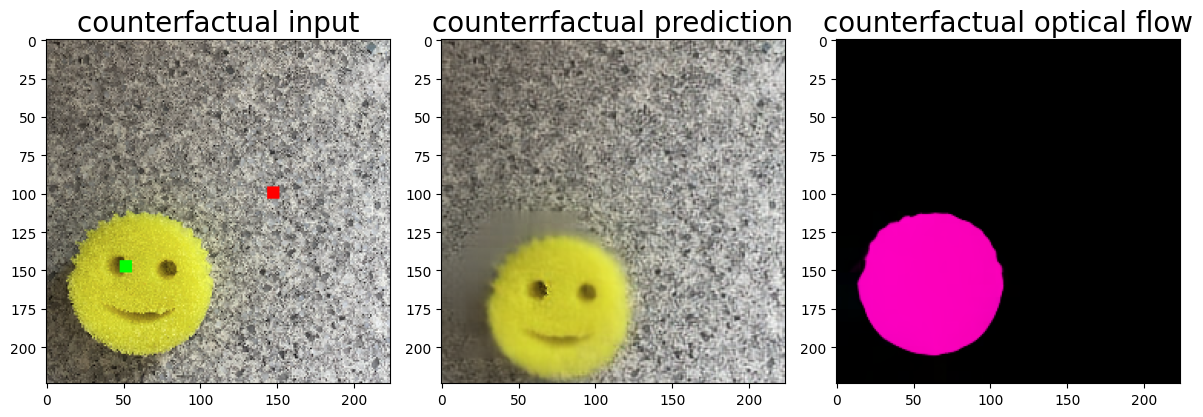

In [31]:
%matplotlib inline
'''
Counterfactual predictions are made by calling
   y_cf = Psi.get_counterfactual_prediction(x, mask, active_patches, shift)
   
   where 
      - x is the image input; if a movie, first frame used
      - active_patches are the patches to be moved
      - mask are the patches to be kept static
      - shift is a 2-list of the motion counterfactual direction (in patch widths)
'''

shift = [2, 2]
active_locs = [ [150, 50] ]
passive_locs = [ [100, 150] ]

Psi.set_input(x)
active_mask = Psi.generate_mask_from_patch_idx_list(active_locs)
passive_mask = Psi.generate_mask_from_patch_idx_list(passive_locs)

y_cf = Psi.get_counterfactual_prediction(x[:,0],
                                         mask=passive_mask,
                                         active_patches=active_mask,
                                         shift=shift,
                                         fix_passive=False # this will make sure only first frame of x is used
                                        )

x_cf = Psi.get_masked_pred_patches(
    Psi.make_static_movie(x[:,0:1], T=2),
    mask=active_mask, invert=False,
    fill_value=[0,1,0]
)
x_cf = Psi.get_masked_pred_patches(
    x_cf,
    mask=passive_mask, invert=False,
    fill_value=[1,0,0]
)
flow_cf = Psi.predict_flow(y_cf)

fig, axes = plt.subplots(1,3,figsize=(12,4))
imshow(x_cf[:,1], ax=axes[0], title='counterfactual input')
imshow(y_cf[:,1], ax=axes[1], title='counterrfactual prediction')
Psi.flowshow(flow_cf, ax=axes[2], title='counterfactual optical flow')

plt.tight_layout()
plt.show()                                        